In [2]:

from multiprocessing.connection import wait
from re import M
import re
import socket
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:

def Get_path_img():
    path = 'E:\\Year4_Sec1\\Image_Pro\\final_exam\\data\\test_12_12'
    path_img = ''
    for i in os.listdir(path):
        path_img = i
    return path +'\\'+ path_img
  
def Invert_Coor(center):
    
    w_real = center[0]
    h_real = center[1]

    h_origin = 85 #mm
    w_origin = 114

    h_pixel = 960
    w_pixel = 1280

    w_real = int(np.floor((w_real/w_pixel)*w_origin))
    h_real = int(np.floor((h_real/h_pixel)*h_origin))

    return [w_real, h_real]


def Processing():
    path = Get_path_img()
    image = cv2.imread(path)
    img = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21) #lọc nhiễu ảnh
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)	#chuyển sang ảnh xám
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,27,4) 
    #to detect coutour of image using gaussian filter. Adjust 2 last params to match your image

    # Apply HoughLinesP method to
    # to directly obtain line end points
    lines = cv2.HoughLinesP(
                img, # Input edge image
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=100, # Min number of votes for valid line
                minLineLength=200, # Min allowed length of line
                maxLineGap=2 # Max allowed gap between line for joining them
                )
    rows = img.shape[0]
    # Apply HoughCircles method to
    # to directly obtain line end points
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, rows / 8,
                                param1=200, param2=30,
                                minRadius=120, maxRadius=1000)

    center_shape=[] #mảng lưu tâm tất cả shape 
    #CIRCLE
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv2.circle(image, center, 5, (0, 100, 100), 3)
            # circle outline
            radius = i[2]
            #print(radius)
            cv2.circle(image, center, radius, (255, 0, 255), 3)
            print("The Circle Dectected: Center = (%2.2f, %2.2f), Radius = %2.2f"%(i[0], i[1], i[2]))

            center = Invert_Coor(center)
            center_shape.append(center)
    else:
        print("Do not dectect the Circle")
        center_shape.append([None, None])
  
    #RECTANGLE
    if lines is not None:
        d=[] # chưa độ dài các cạnh được dectect
        d_ = []
        for i, points  in enumerate(lines):
   
            x1,y1,x2,y2=points[0]
            d.append([i,np.sqrt(pow((x2-x1),2)+pow((y2-y1),2))])
   
        d = np.array(d)


        d_=np.argsort(d[:,1],kind='quicksort') #sort từ lớn đến bé
   
        d_[:] = d_[::-1]
     
        lines_list =[] #mảng lưu tọa độ đoạn thẳng
        cent_list = [] #mảng lưu trung điểm đoạn thẳng
        for stt, i in enumerate(d_): #Lọc 2 cạnh đối nhau của hình vuông
            x1,y1,x2,y2=lines[i][0] #lấy tọa độ cạnh
            #tìm trung điểm cạnh
            x_av = int(np.floor(abs(abs(x1+x2))/2))
            y_av = int(np.floor(abs(abs(y1+y2))/2))
            if stt == 0: #lưu cạnh độ dài lớn nhất 
                print('4')
                d_1_x = x_av
                d_1_y = y_av
                cv2.line(image,(x1,y1),(x2,y2),(0,255,0),3)
                cv2.drawMarker(image, (x_av, y_av),(0,0,255), markerType=cv2.MARKER_STAR, markerSize=40, thickness=1, line_type=cv2.LINE_AA)
                # Maintain a simples lookup list for points
                lines_list.append([(x1,y1),(x2,y2)])
                cent_list.append([d_1_x,d_1_y])
            d_break = np.sqrt(pow((d_1_x-x_av),2)+pow((d_1_y-y_av),2))
            
            if d_break > 250 and d_break < 350:	#tìm cạnh đối
                print('5')
                cv2.line(image,(x1,y1),(x2,y2),(255,255,0),3)
                cv2.drawMarker(image, (x_av, y_av),(0,0,255), markerType=cv2.MARKER_STAR, markerSize=40, thickness=1, line_type=cv2.LINE_AA)
                # Maintain a simples lookup list for points
                lines_list.append([(x1,y1),(x2,y2)])
                cent_list.append([x_av,y_av])
                break
        #print(len(lines_list),d)
        x_cen = int(np.floor(abs(abs(cent_list[0][0]+cent_list[1][0]))/2))
        y_cen = int(np.floor(abs(abs(cent_list[0][1]+cent_list[1][1]))/2))
        cv2.drawMarker(image, (x_cen, y_cen),(255,0,255), markerType=cv2.MARKER_STAR, markerSize=40, thickness=1, line_type=cv2.LINE_AA)
        print("The rectangle dectected: Center = (%2.2f, %2.2f), Side length= %2.2f"%(x_cen, y_cen, d_break))
        Invert_Coor([x_cen,y_cen])
        center_shape.append(Invert_Coor([x_cen,y_cen]))
    else:
        print("Do not dectect the Rectangle")
        center_shape.append([None, None])
    center_tmp = str(center_shape[0][0])+";"+str(center_shape[0][1])+";"+str(center_shape[1][0])+";"+str(center_shape[1][1])
    #center_tmp = str(center_shape[0][0])+str('o')
    plt.imshow(image)
    plt.show()
    return center_tmp


The Circle Dectected: Center = (202.00, 274.00), Radius = 147.00
4
5
The rectangle dectected: Center = (431.00, 600.00), Side length= 286.68


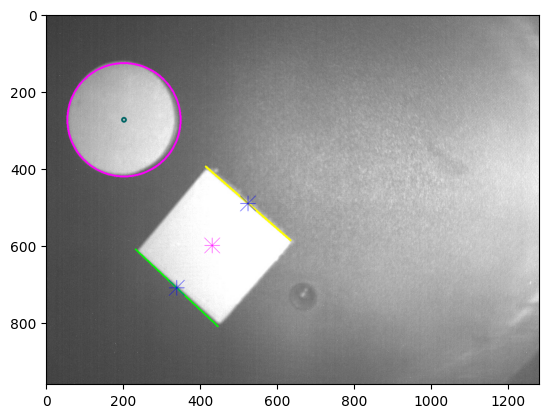

'17;24;38;53'

In [13]:
Processing()